# Virtual state generated with separable contact interaction

## System and potential

We start once again by defining a system with mass $m=1$ and $\hbar=1$.

In [1]:
from lib.system import *

sys = System()

print(sys)

System(mass=1.0, scale=1.0)


And we keep using a separable contact interaction:

\begin{equation}
 V(p,q) = C_0 g(p) g(q) \ ,\ g(p) = \exp({-}p^2/\Lambda^2) \,.
\end{equation}

In [7]:
from lib.potential import *

import numpy as np

class GaussContactPotential(Potential):
  def __init__(self, sys, C0, Lambda):
    super().__init__(sys, "V_GaussContact")
    
    self.C0 = C0
    self.Lambda = Lambda
    
  def get(self, ell, p, q):
    if ell != 0:
      raise RuntimeError("Invalid angular momentum!")
      
    def g(p):
      return np.exp(-p**2 / self.Lambda**2)
    
    return self.C0 * g(p) * g(q)

In the limit $\Lambda\to\infty$ we obtain a pure contact (zero-range) interaction.

## Equation solving and interaction fitting

The infrastructure for determining $C_0$ is also exactly the same as before:

In [8]:
from lib.mesh import *
from lib.operator import *

mesh = GaulegMesh(16, 0.0, 4.0)

G0 = G_0(sys)

In [9]:
def kernel(V, E):
  factor = 0.5 / np.pi**2
                                                                                     
  K = map(
    lambda p: list(map(
      lambda qw: factor * qw[1] * qw[0]**2 \
        * (G0.residue(qw[0]) if qw[2] else G0(E, qw[0])) \
        * V.get(0, p, qw[0]),
      mesh.pws()
    )), mesh.ps()
  )

  return np.asarray(list(K))  

In [10]:
def solve_on_shell(V, k):
  i0 = mesh.push_pv(k)
  
  mat = np.identity(mesh.size()) - kernel(V, sys.e_from_k(k))
  vec = np.asarray(list(map(lambda p: V.get(0, p, k), mesh.ps())))
  
  sol = np.linalg.solve(mat, vec)
  
  mesh.pop_pv()
  
  return sol[i0];

In [11]:
p0 = 0.001

def a_scatt(C0):
  return 0.5 * sys.mu / np.pi * solve_on_shell(
    GaussContactPotential(sys, C0, Lambda),
    p0
  ).real

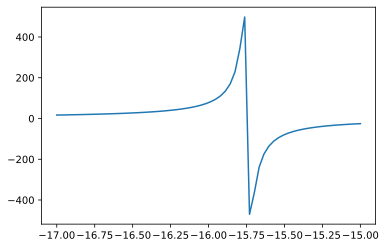

In [12]:
Lambda = 2.0

mesh = GaulegMesh(32, 0.0, 3.0 * Lambda)

c0s = np.linspace(-17.0, -15.0, 64)

plt.plot(c0s, np.vectorize(a_scatt)(c0s))
plt.show()

However, we now determine $C_0$ such that we obtain a *large negative scattering length* $a_0={-}50.0$:

In [13]:
from scipy.optimize import root_scalar

In [15]:
a0 = -50.0

root = root_scalar(
  lambda c: a_scatt(c) - a0,
  method='secant',
  x0=-15.6,
  x1=-15.5
)

print(root)

      converged: True
           flag: 'converged'
 function_calls: 9
     iterations: 8
           root: -15.360055540265424


In [16]:
V0 = GaussContactPotential(sys, root.root, Lambda)

## Bound-state and virtual-state searches

If we look for a bound state, we can now see there is none:

In [17]:
def det(E):
  return np.linalg.det(np.identity(mesh.size()) - kernel(V0, E))

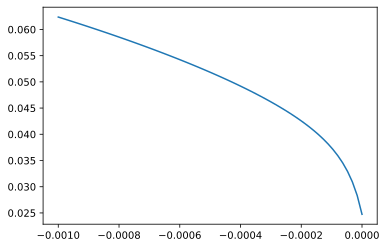

In [18]:
es = np.linspace(-0.001, 0.0, 64)

plt.plot(es, np.vectorize(det)(es))
plt.show()

Indeed, we can easilty see that this should be so by considering again the T-matrix:

\begin{equation}
 T(E_k;k,k) = {-}\frac{2\pi}{\mu}\frac{1}{{-}1/a+\cdots-\mathrm{i}k}
\end{equation}

Neglecting the "$\cdots$," this has a pole at $k=\mathrm{i}/{a}$.  For $a>0$ this gives the bound state we found previously.  But now that we picked $C_0$ such that we get $a<0$, we see that the pole has moved to the
negative imaginary axis, i.e., it has become a **virtual state**.

In the energy plane, it is located on the second sheet, so we need to analytically continue the Lippmann-Schwinger equation to find it.  In the lecture it was shown that this can be achieved by replacing the potential with a modified expression:

\begin{equation}
 V(p,q) \rightarrow \tilde{V}(q_0;p,q) = V(p,q) - V(p,q_0)
 \frac{\mathrm{i}\mu q_0/\pi}{1 + \mathrm{i}\mu q_0/\pi V(q_0,q_0)}
 V(q_0,q) \,,
\end{equation}

where $q_0 = \sqrt{2\mu E}$.

This is straightforward to implement:

In [22]:
class V_cont(Potential):
  def __init__(self, sys, V, q0):
    super().__init__(sys, "V_cont")
    
    self.V = V
    self.q0 = q0
    
  def get(self, ell, p, q):
    factor = self.sys.mu * 1.0j * self.q0 / np.pi
    
    v0 = self.V.get(ell, self.q0, self.q0)
    v1 = self.V.get(ell, p, self.q0)
    v2 = self.V.get(ell, self.q0, q)
    
    return self.V.get(ell, p, q) - v1 * factor / (1.0 + factor * v0) * v2

With this "adaptor" potential class, we can define the determinant function to search for a solution of the homogeneous equation on the second sheet.  For the special case of searching for a virtual state (real $E<0$)
we manually pick the appropriate branch of the square root to obtain $q_0$ with $\text{Im}\,q_0<0$:

In [23]:
def det_II(E):
  q0 = -np.sqrt(2.0 * sys.mu * (E + 0j))
  VV = V_cont(sys, V0, q0)
  
  return np.linalg.det(np.identity(mesh.size()) - kernel(VV, E)).real

As before, we first look at a plot...

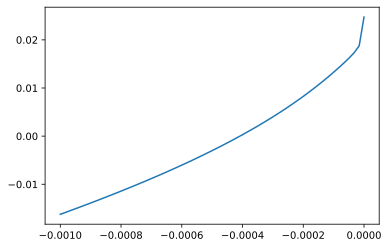

In [24]:
es = np.linspace(-0.001, 0.0, 64)

plt.plot(es, np.vectorize(det_II)(es))
plt.show()

...and then properly search for the virtual state:

In [25]:
root = root_scalar(
  det_II,
  method='secant',
  x0=-0.0006,
  x1=-0.0005
)

print(root)

      converged: True
           flag: 'converged'
 function_calls: 5
     iterations: 4
           root: -0.0004087617426198217


Again we observe decent agreement with the expectation $E = {-}1/(2\mu a_0^2)$:

In [26]:
print(-1.0 / (2.0 * sys.mu * a0**2))

-0.0004


The relative deviation from the exact zero-range result is of the same order as for the bound state we found corresponding to $a_0={+}50.0$.